# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2024-02-23 17:45:31.639781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [2]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context  

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/miguelopez/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

df = raw_dataset.copy()
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpia los datos

Trata los missings y variables categóricas

In [5]:
# Check missing values for each column.
df.isna().sum() 

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
#The "Origin" column is really categorical, not numeric. So convert that to a one-hot
origin = df.pop('Origin')

In [8]:
df['USA'] = (origin == 1)*1.0
df['Europe'] = (origin == 2)*1.0
df['Japan'] = (origin == 3)*1.0
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [9]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

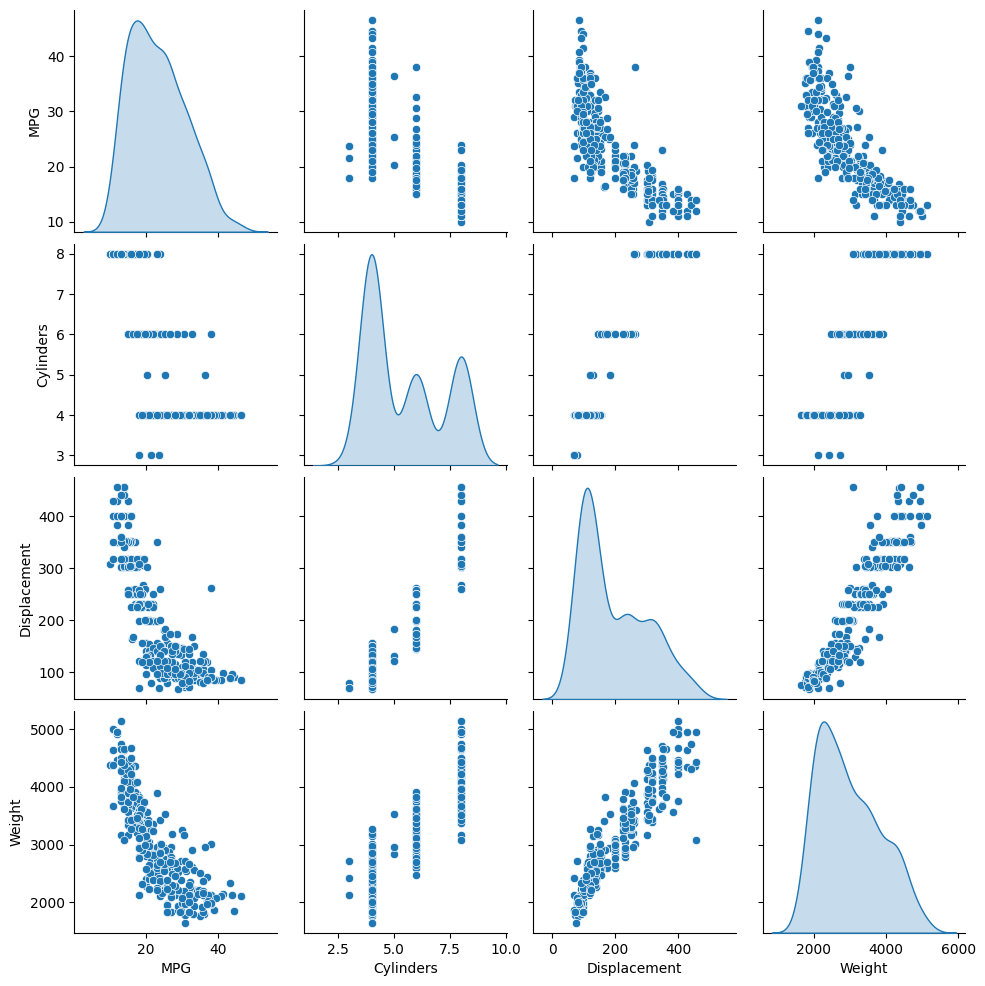

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde");

Tambien revise las estadisticas generales:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separa las features del target

Separe el target de las features.

In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

* Feature normalization makes model training easier and less dependent on input units by scaling all features to have similar ranges. The same normalization statistics calculated from the training data are applied to the test data so it matches the distribution the model was trained on.

Normalization makes the training process more efficient and effective, and leads to models that generalize better to new data. Matching the normalization of the training and test data ensures consistency.


In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

Normalizing the training and test data key reasons:

It puts all features on the same scale. Since features often have different units/ranges, normalization avoids one feature dominating just because its values are larger.

It helps optimization converge faster. Many machine learning optimization algorithms converge faster when features are normalized. The objective function landscape becomes smoother.

It reduces the dependence on the choice of units. By normalizing, you avoid features being weighted differently just because they were measured in different units.

It allows the model to generalize better. Normalizing using statistics from the training data causes the model to focus more on the patterns in the data rather than absolute values. This improves generalization to new data.

It enables gradient descent to converge faster. The gradients descent more uniformly when feature values are normalized, allowing faster convergence.






## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [14]:
model = keras.Sequential([
layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
layers.Dense(64, activation='relu'),
layers.Dense(1)
])


model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'mse'])

Layers are added sequentially one after the other.

It has two hidden layers that are densely connected neural networks (Dense layer). These hidden layers allow the model to learn complex relationships between the input features and output.


The output layer has a single node because this is a regression problem, predicting a continuous value. For classification we would use more output nodes.




### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Summary of the model architecture showing the layers, output shape, and parameters.

* 3 layer fully connected network architecture with input -> 64 nodes -> 64 nodes -> 1 output. The parameter counts reflect the node connections.


3 Dense layers (fully connected layers):

* First layer has 64 nodes
* Second layer has 64 nodes
* Third layer has 1 node for output

Output Shape shows the shape of output from each layer:

* First layer: (None, 64) - None is batch size, 64 nodes
* Second layer: (None, 64) - 64 nodes again
* Third layer: (None, 1) - 1 output node

Param # counts the trainable parameters in each layer:

* First layer: 64 * input size + 64 = 704 parameters
* Second layer: 64 * 64 + 64 = 4160 parameters (64 nodes x 64 input nodes + 64 biases)
* Third layer: 64 * 1 + 1 = 65 parameters
Total trainable parameters = 704 + 4160 + 65 = 4929







### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [16]:
history = model.fit(
  normed_train_data, train_labels,
  epochs=1000, validation_split = 0.2, verbose=0)

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.490492,1.051624,2.490492,11.242869,2.555354,11.242869,995
996,2.490887,1.045568,2.490887,11.055497,2.475777,11.055497,996
997,2.424851,1.021044,2.424851,11.039754,2.522258,11.039754,997
998,2.549762,1.048204,2.549762,11.282335,2.503702,11.282335,998
999,2.456807,1.016169,2.456807,11.150045,2.486645,11.150045,999


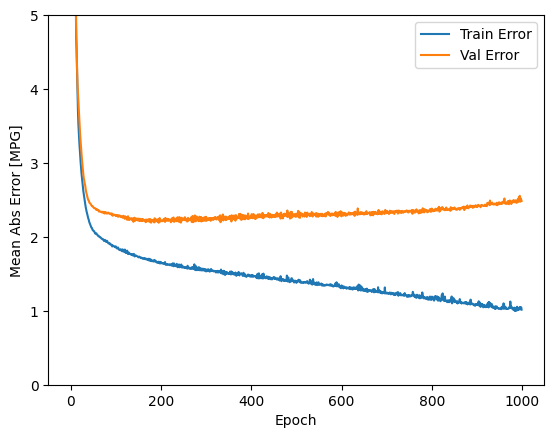

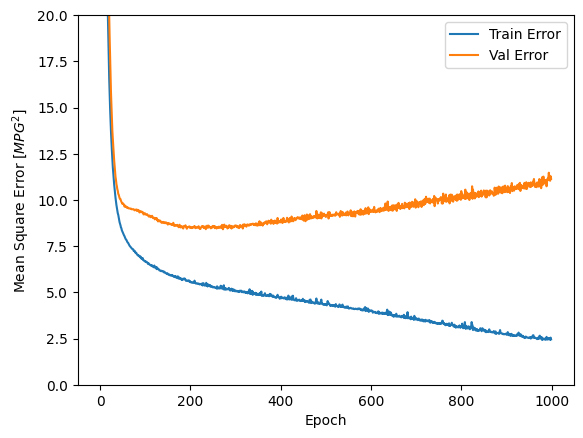

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

¿Alguna conclusión respecto a este gráfico?

The validation error is not improving or even getting worse after many epochs, indicating overfitting.






Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

EarlyStopping automatically stop training when the validation metric stops improving.

This will prevent overfitting by not training for too many epochs.

EarlyStopping tests a condition each epoch like validation loss not decreasing.

If the condition does not improve for a set number of epochs, EarlyStopping will automatically stop training.


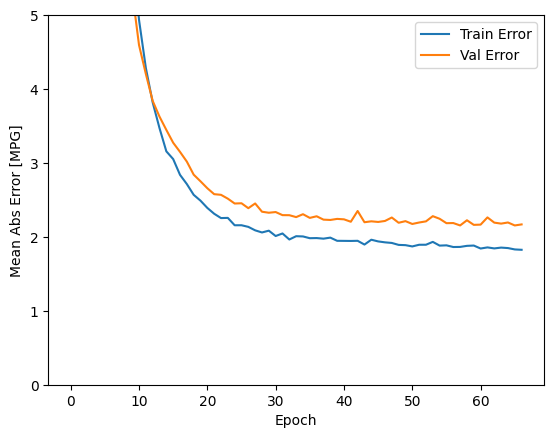

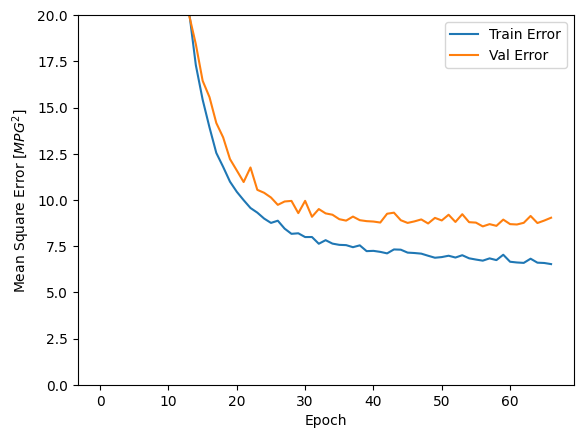

In [20]:
model = keras.Sequential([
layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
layers.Dense(64, activation='relu'),
layers.Dense(1)
])


model.compile(loss='mse',
            optimizer=tf.keras.optimizers.RMSprop(0.001),
            metrics=['mae', 'mse'])


# The patience parameter is the amount of epochs to check for improvement
history = model.fit(normed_train_data,
                    train_labels, epochs=1000,
                    validation_split = 0.2,
                    verbose=0,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

plot_history(history)

Interpreta el gráfico

The validation error plot shows the error is fluctuating around +/- 2 MPG.

Whether this is a good/acceptable error or not, it depends on the specific application.

For a regression problem predicting MPG, +/- 2 MPG may be reasonable.

But for other applications, +/- 2 units of the target variable could be poor performance.

So it's difficult to say if +/- 2 MPG error is good or bad in absolute terms.



Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.3712 - mae: 1.9986 - mse: 6.3712 - 48ms/epoch - 16ms/step
Testing set Mean Abs Error:  2.00 MPG


Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [23]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 150ms/step


array([[29.669804],
       [24.904585],
       [12.824252],
       [38.46905 ],
       [35.74402 ],
       [21.132008],
       [37.868423],
       [31.410698],
       [19.189762],
       [24.295435]], dtype=float32)

In [24]:
train_labels[:10]

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
Name: MPG, dtype: float64

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

3/3 [==============================] - 0s 5ms/step


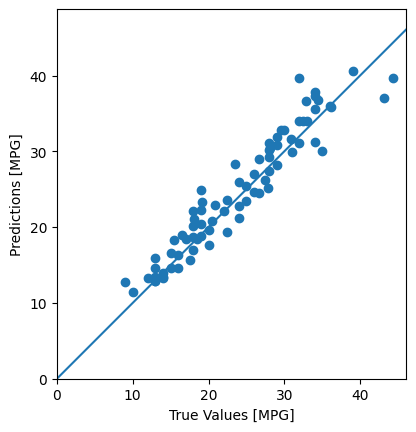

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [28]:
from sklearn.metrics import r2_score
# Predictions fitting the true labels
r2 = r2_score(test_labels, test_predictions)
print("R-squared:", r2)


R-squared: 0.9024422668103395


In [30]:
# Mean and standard deviation of the errors.
errors = test_predictions - test_labels
print("Mean error:", errors.mean())
print("STD of errors:", errors.std())

Mean error: 0.7765629621652457
STD of errors: 2.4172372022943276


Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

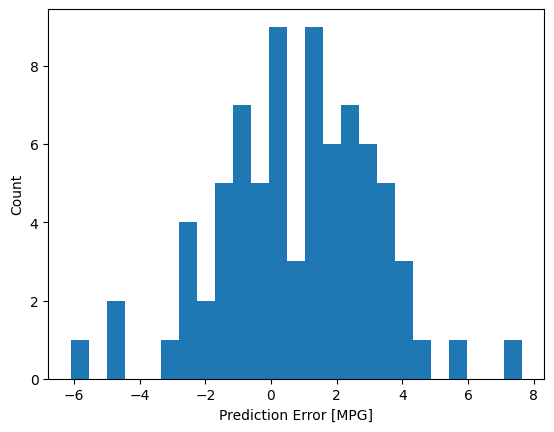

In [26]:
# Inspect the distribution of errors
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

{'bodies': [<matplotlib.collections.PolyCollection at 0x13bd1b750>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x13bd1a410>,
 'cmins': <matplotlib.collections.LineCollection at 0x13bd5dbd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x13bd5d850>}

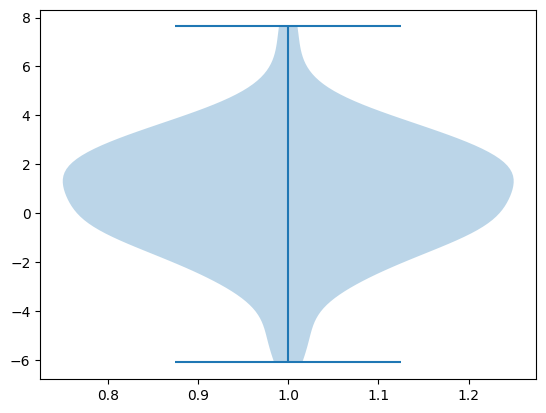

In [35]:
plt.violinplot(error)

Density range: 0.0 3.0


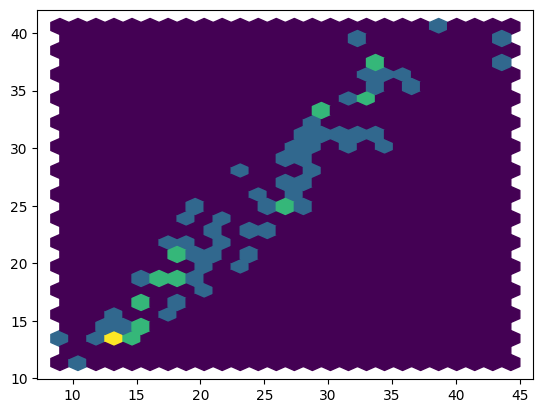

In [39]:
hb = plt.hexbin(test_labels, test_predictions, gridsize=25)

dens = hb.get_array()
print("Density range:", dens.min(), dens.max())

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.

Loss Function:

* MSE (Mean Squared Error) to measure model error for regression. Different from classification loss.
Evaluation Metric:

* MAE (Mean Absolute Error) is a common metric to evaluate regression model performance. Different from classification metrics.
Feature Scaling:

* Scale numeric input features to same range. Otherwise, features with larger ranges may dominate.
Model Size:

With small data, use smaller model with few hidden layers. Avoids overfitting.

* Early Stopping:

* Stop training before model overfits data. Prevents improving on training data but worse on validation data.

